# Diabetes Risk Analysis - Clustering & Segmentation

***

## Scope of Notebook

This analysis employs **Unsupervised Learning** techniques to identify distinct population segments based on health and lifestyle indicators. The primary objective involves discovering natural groupings of individuals with similar health profiles to inform targeted public health interventions.

Table of contents:

*   [1. K-Means Clustering](#1-k-means-clustering)
*   [2. K-Prototypes for Mixed Data](#2-k-prototypes-for-mixed-data)
*   [3. Hierarchical Clustering (Discovery Phase)](#3-hierarchical-clustering-discovery-phase)
*   [4. Comparative Evaluation](#4-comparative-evaluation)
*   [5. Export Enriched Dataset with Cluster Labels](#5-export-enriched-dataset-with-cluster-labels)
*   [6. SHAP Analysis (Clustering Interpretation)](#6-shap-analysis-clustering-interpretation)

In [10]:
# Install kmodes for K-Prototypes if not already installed
%pip install kmodes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Configuration
%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Load and Configure Data for All Clustering Models
# NB: We prefer using the PCA_transformed data for high-efficiency clustering (K-Means/Hierarchical)
# But for K-Prototypes / Interpretation, we need the original scaled features as well.

# UPDATED: Using .pkl files for faster IO and type preservation
file_path_scaled = '../data/processed/diabetes_scaled.pkl'
file_path_pca = '../data/processed/pca_transformed.pkl'

try:
    # 1. Load Scaled Data (Original Features) - for Interpretation & K-Prototypes
    df = pd.read_pickle(file_path_scaled)
    # The 'df' loaded (diabetes_scaled.pkl) has the target 'Diabetes_012' - we must exclude it from training
    X_raw_scaled = df.drop('Diabetes_012', axis=1, errors='ignore').copy()
    
    # 2. Load PCA Data - for Efficiency (K-Means / Hierarchical)
    df_pca_input = pd.read_pickle(file_path_pca)
    # Separate Target from PCA data for clustering training
    X_pca_train = df_pca_input.drop('Diabetes_012', axis=1, errors='ignore')

    print("Datasets loaded successfully via Pickle.")
    print(f"Scaled Raw Features Shape: {X_raw_scaled.shape}")
    print(f"PCA Reduced Features Shape: {X_pca_train.shape}")

    # 3. Global Feature Identification (Optimised Solution)
    # We define identifying lists here so ALL models (especially K-Prototypes) use the same feature definitions.
    # Categorical (Low Cardinality): 
    # - Metabolic_Syndrome_Index (0-4 score)
    # - Healthy_Habit_Score (0-3 score) 
    # - Sedentary_Risk (Binary) 
    # Continuous:
    # - Physical_Distress_Ratio (0.0 - 1.0)
    # - Age (Continuous range)

    # Note: If your feature names differ or change in Notebook 01, update this list here.
    
    # REVISED: 'Physical_Distress_Ratio' is CONTINUOUS.
    cat_features = ['Metabolic_Syndrome_Index', 'Healthy_Habit_Score', 'Sedentary_Risk']
    
    # Explicitly defining Continuous features to ensure Physical_Distress_Ratio is caught correctly 
    # (and not accidentally put in cat_features or missed)
    desired_cont_features = ['Physical_Distress_Ratio', 'Age']
    
    # Validate against actual columns in dataframe
    # 1. Categorical Validation
    cat_features = [c for c in cat_features if c in X_raw_scaled.columns]
    
    # 2. Continuous Validation (including the Ratio and Age)
    cont_features = [c for c in X_raw_scaled.columns if c in desired_cont_features]
    
    # Fallback: if list is empty (maybe variable usage from old file?), revert to "everything else" logic
    if not cont_features:
         cont_features = [c for c in X_raw_scaled.columns if c not in cat_features]
    
    print("\nGlobal Feature Definitions for K-Prototypes/Interpretation:")
    print(f"Categorical (Discrete): {cat_features}")
    print(f"Continuous: {cont_features}")

except FileNotFoundError:
    print(f"Files not found. Please ensure 01_eda_and_prep.ipynb has been run successfully.")

Datasets loaded successfully via Pickle.
Scaled Raw Features Shape: (229781, 7)
PCA Reduced Features Shape: (229781, 7)

Global Feature Definitions for K-Prototypes/Interpretation:
Categorical (Discrete): ['Metabolic_Syndrome_Index', 'Healthy_Habit_Score', 'Sedentary_Risk']
Continuous: ['Physical_Distress_Ratio', 'Age']


## 1. K-Means Clustering

**K-Means** serves as the primary clustering algorithm due to the dataset size (~250k rows). This algorithm demonstrates computational efficiency and proves well-suited for large-scale numerical data, making it appropriate for identifying population segments based on health risk factors.

### 1.1 Optimization (Grid Search: Elbow & Silhouette)

A Grid Search is performed to identify optimal hyperparameters:
*   **Number of Clusters (k):** Range from 2 to 10.
*   **Initialization Method:** Comparison of `'k-means++'` (smart centroid initialization) versus `'random'`.

Evaluation of these combinations employs:
*   **Elbow Method (Inertia):** Identification of the point of diminishing returns in variance reduction.
*   **Silhouette Score:** Maximization of cluster cohesion and separation (calculated on a sample).

Performing PCA Analysis to determine optimal components...


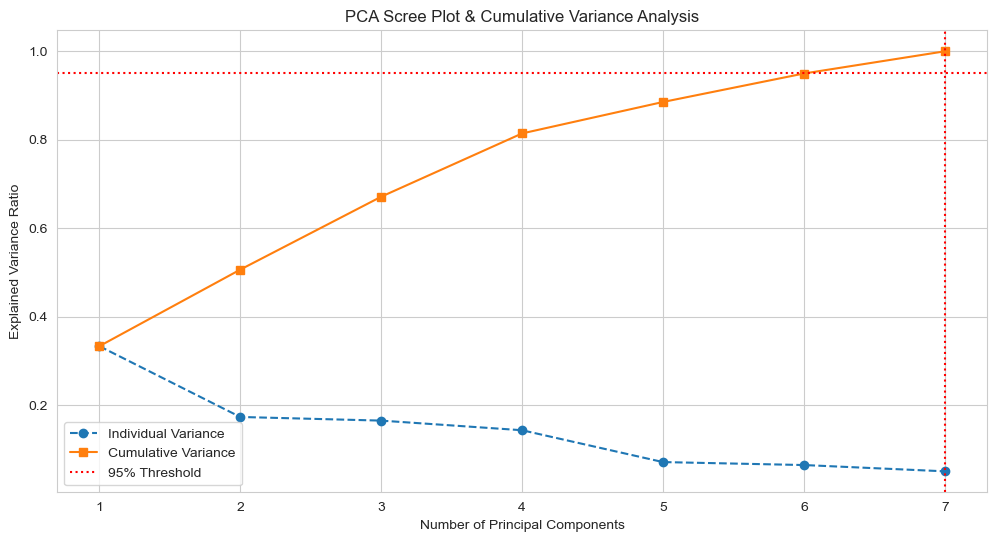

Optimal Number of Components (95% Variance): 7
Explained Variance by Component: [0.33318364 0.17311854 0.16487221 0.14311351 0.07110636 0.06440151
 0.05020424]
Transformed Clustering Dataset Shape: (229781, 7)
------------------------------------------------------------
Global X_pca_train updated with optimized components.


In [12]:
# 1.1 PCA Optimization & Dimensionality Reduction (Scree Plot)
# We regenerate the PCA model here to visualise the Variance and Select Components Dynamically.
# This ensures we retain exactly 95% of the variance as per the advanced methodology.

# Using the Global Scaled Feature Set (defined in Data Loading step)
X_pca_input = X_raw_scaled.copy()

print("Performing PCA Analysis to determine optimal components...")

# Fit PCA with maximum components
pca_full = PCA()
pca_full.fit(X_pca_input)

# Calculate Cumulative Variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Determine Components for 95% Variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Plot Scree Plot & Cumulative Variance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle=':', label='95% Threshold')
plt.axvline(x=n_components_95, color='r', linestyle=':')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot & Cumulative Variance Analysis')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Number of Components (95% Variance): {n_components_95}")
print(f"Explained Variance by Component: {explained_variance[:n_components_95]}")

# Create the Optimized Dimension-Reduced Dataset for Clustering
pca_opt = PCA(n_components=n_components_95)
X_kmeans = pd.DataFrame(pca_opt.fit_transform(X_pca_input))
X_kmeans.index = X_pca_input.index # Update: Preserve original index to ensure alignment with df for downstream tasks
X_kmeans.columns = [f"PC{i+1}" for i in range(n_components_95)]

print(f"Transformed Clustering Dataset Shape: {X_kmeans.shape}")
print("-" * 60)

# Sync global PCA training set for downstream tasks (Hierarchical)
# This ensures Step 3 uses the same 95% variance components
X_pca_train = X_kmeans.copy()
print("Global X_pca_train updated with optimized components.")

Running Grid Search (k=2-10, init methods) on sample size 10000...
K     | Init            | Inertia         | Silhouette     
------------------------------------------------------------
2     | k-means++       | 1245301       | 0.2728
2     | k-means++       | 1245301       | 0.2728
2     | random          | 1245301       | 0.2724
2     | random          | 1245301       | 0.2724
3     | k-means++       | 1051063       | 0.2041
3     | k-means++       | 1051063       | 0.2041
3     | random          | 1051061       | 0.2041
3     | random          | 1051061       | 0.2041
4     | k-means++       | 919194       | 0.2028
4     | k-means++       | 919194       | 0.2028
4     | random          | 919193       | 0.2028
4     | random          | 919193       | 0.2028
5     | k-means++       | 824067       | 0.1945
5     | k-means++       | 824067       | 0.1945
5     | random          | 824067       | 0.1945
5     | random          | 824067       | 0.1945
6     | k-means++       | 765338    

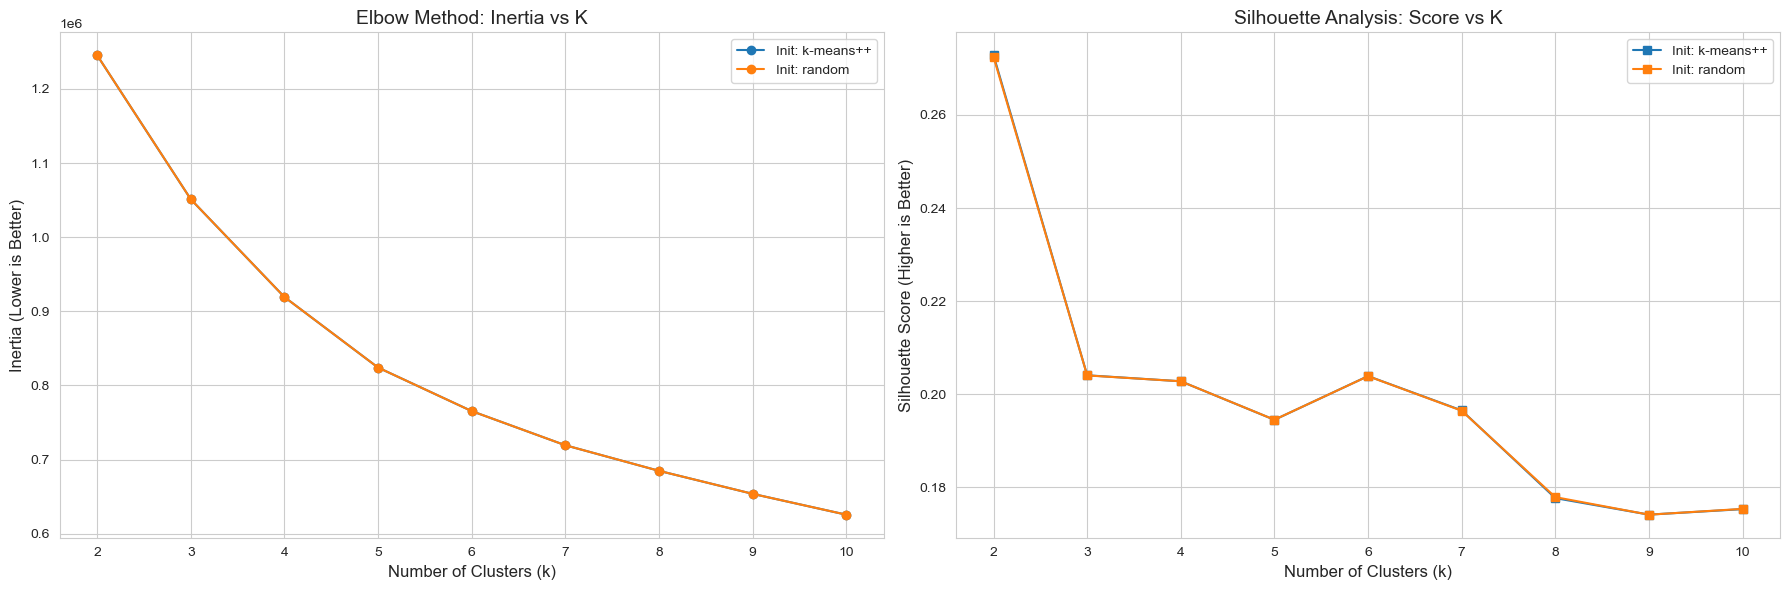


Best Configuration based on Silhouette Score:
k = 2
Init = k-means++
Silhouette Score = 0.2728


In [13]:
# Sample for Silhouette Score (to reduce computation time)
sample_size = 10000
# Use X_kmeans instead of df
df_sample = X_kmeans.sample(n=sample_size, random_state=42)

# Grid Search Parameters
K_range = range(2, 11)
init_methods = ['k-means++', 'random']

results = []

print(f"Running Grid Search (k=2-10, init methods) on sample size {sample_size}...")
print(f"{'K':<5} | {'Init':<15} | {'Inertia':<15} | {'Silhouette':<15}")
print("-" * 60)

for k in K_range:
    for init in init_methods:
        # Initialize KMeans with specific parameters
        kmeans = KMeans(n_clusters=k, init=init, random_state=42, n_init=10)
        
        # Fit on full data (X_kmeans) for robust Inertia calculation
        kmeans.fit(X_kmeans)
        inertia = kmeans.inertia_
        
        # Calculate Silhouette on Sample
        labels_sample = kmeans.predict(df_sample)
        score = silhouette_score(df_sample, labels_sample)
        
        results.append({
            'k': k,
            'init': init,
            'inertia': inertia,
            'silhouette': score
        })
        
        print(f"{k:<5} | {init:<15} | {inertia:.0f} {'':<5} | {score:.4f}")

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Plotting Grid Search Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Elbow Method (Inertia)
for init in init_methods:
    subset = results_df[results_df['init'] == init]
    ax1.plot(subset['k'], subset['inertia'], marker='o', label=f'Init: {init}')

ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Lower is Better)', fontsize=12)
ax1.set_title('Elbow Method: Inertia vs K', fontsize=14)
ax1.legend()
ax1.grid(True)

# Plot 2: Silhouette Score
for init in init_methods:
    subset = results_df[results_df['init'] == init]
    ax2.plot(subset['k'], subset['silhouette'], marker='s', label=f'Init: {init}')

ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score (Higher is Better)', fontsize=12)
ax2.set_title('Silhouette Analysis: Score vs K', fontsize=14)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Identify Best Configuration (Max Silhouette)
best_run = results_df.loc[results_df['silhouette'].idxmax()]
print(f"\nBest Configuration based on Silhouette Score:")
print(f"k = {best_run['k']}")
print(f"Init = {best_run['init']}")
print(f"Silhouette Score = {best_run['silhouette']:.4f}")

### 1.2 Implementation & Visualization

The final K-Means model is fitted using the optimal *k* determined from the grid search analysis.

**Methodological Note:** Clustering is performed on **High-Dimensional PCA data** (training on 95% variance components). However, for **visualization** purposes, projection onto the first 2 Principal Components creates a readable 2D scatter plot. This approach ensures the model learns from the full complexity of the data while maintaining interpretable visual output.

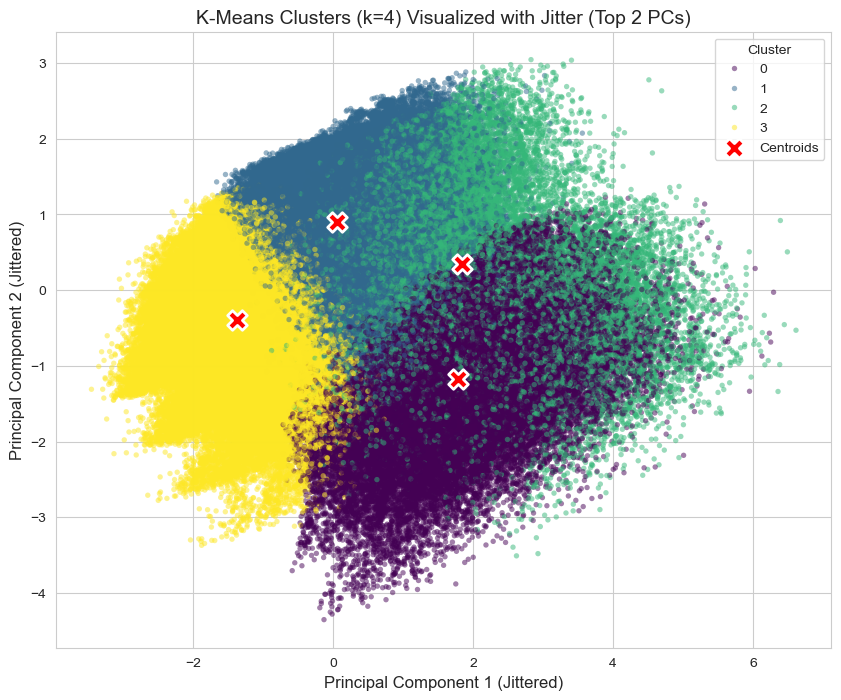

Cluster labels assigned to main dataframe.


Cluster_KMeans
3                 87282
1                 78289
0                 37785
2                 26425
Name: count, dtype: int64

In [24]:
# Visualization Configuration
final_k = 4  # Adjust this based on step 1 results (Elbow/Silhouette)

# 1. Fit Final K-Means Model on ALL PCA Components (High Performance)
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_kmeans)

# 2. Prepare Visualization Data (Using just PC1 and PC2)
# We can simply take the first two columns of our PCA dataframe
viz_df = X_kmeans.iloc[:, :2].copy()
viz_df.columns = ['PC1', 'PC2']
viz_df['Cluster'] = cluster_labels

# Add Random Jitter (Noise) to handle overlap in large datasets
# This helps distinguish density in the scatterplot
jitter_strength = 0.05
viz_df['PC1_Jitter'] = viz_df['PC1'] + np.random.normal(0, jitter_strength, size=len(viz_df))
viz_df['PC2_Jitter'] = viz_df['PC2'] + np.random.normal(0, jitter_strength, size=len(viz_df))

# 3. Plot Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1_Jitter', y='PC2_Jitter', hue='Cluster', data=viz_df, 
    palette='viridis', alpha=0.5, s=15, linewidth=0
)

# Calculate and Plot Centroids
centroids = viz_df.groupby('Cluster')[['PC1', 'PC2']].mean()
plt.scatter(
    centroids['PC1'], centroids['PC2'], 
    marker='X', s=200, c='red', edgecolors='white', linewidth=2, label='Centroids', zorder=10
)

plt.title(f'K-Means Clusters (k={final_k}) Visualized with Jitter (Top 2 PCs)', fontsize=14)
plt.xlabel('Principal Component 1 (Jittered)', fontsize=12)
plt.ylabel('Principal Component 2 (Jittered)', fontsize=12)
plt.legend(title='Cluster')
plt.show()

# 4. Save Cluster Labels back to main dataframe for downstream profilng
df['Cluster_KMeans'] = cluster_labels
print("Cluster labels assigned to main dataframe.")
display(df[['Cluster_KMeans']].value_counts())

### 1.3 Cluster Profiling (Descriptive Analysis)

Interpretation of the clinical meaning of each cluster requires calculation of mean values for original features within each segment. This profiling characterizes the health profiles and risk levels associated with each identified cluster.

**Interpretation Guide:**
*   **Continuous variables (BMI, PhysHlth):** Values represent Z-scores (centered at 0). Positive values indicate above-average levels.
*   **Binary/Ordinal variables (HighBP, Age, etc.):** Means represent prevalence (e.g., 0.80 = 80% exhibit High BP) or average level.

Profiling 8 numeric features.
K-Means Cluster Profiling Table (Mean Values):


,Count,Percent (%),Metabolic_Syndrome_Index,Physical_Distress_Ratio,Healthy_Habit_Score,Sedentary_Risk,Age,BMI,GenHlth,Diabetes_012
Cluster_KMeans,,,,,,,,,,
0,37785,16.443918,0.414521,-0.085995,-1.082061,2.025690,0.136814,0.649473,0.216971,0.483313
1,78289,34.071137,0.619239,-0.351017,0.322569,-0.493578,0.399369,0.327575,0.057041,0.433190
2,26425,11.500081,0.413948,2.220571,-0.290747,0.175010,0.160483,0.155296,1.440969,0.602687
3,87282,37.984864,-0.860210,-0.320209,0.267123,-0.487198,-0.466036,-0.622002,-0.581351,0.077003



Visual Profiling (Snake Plot):


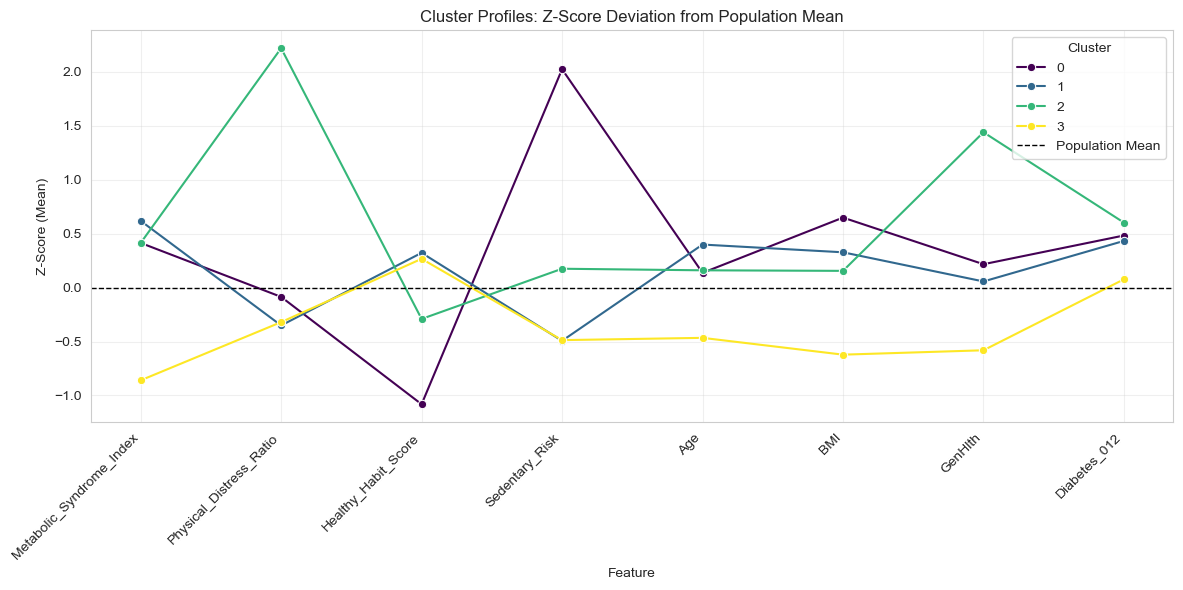

In [15]:
# Define features to profile (excluding the PC columns or labels)
# We use the columns from the loaded 'df' which are the original features (some scaled)
# We exclude 'Cluster_KMeans' and 'Cluster_Proto' (if it exists) to avoid errors
cols_to_exclude = ['Cluster_KMeans', 'Cluster_Proto']

# FIX: Filter explicitly for numeric columns to prevent TypeError on object columns
# This handles cases where non-numeric columns (like 'Diabetes_Status' or strings) are in df
numeric_profile_cols = []
for col in df.columns:
    if col not in cols_to_exclude and pd.api.types.is_numeric_dtype(df[col]):
        numeric_profile_cols.append(col)

print(f"Profiling {len(numeric_profile_cols)} numeric features.")

# Group by Cluster and calculate mean
cluster_profile = df.groupby('Cluster_KMeans')[numeric_profile_cols].mean()

# Add Count and Percentage
cluster_counts = df['Cluster_KMeans'].value_counts()
cluster_profile['Count'] = cluster_counts
cluster_profile['Percent (%)'] = (cluster_counts / len(df)) * 100

# Reorder columns to put Count/Percent first for readability
cols = ['Count', 'Percent (%)'] + [c for c in cluster_profile.columns if c not in ['Count', 'Percent (%)']]
cluster_profile = cluster_profile[cols]

print("K-Means Cluster Profiling Table (Mean Values):")
# Using a gradient to highlight High (Red) vs Low (Green) values
# Note: For 'Fruits', 'Veggies', 'PhysActivity', higher is technically 'better', but for consistency:
# Darker colors = Higher Values.
display(cluster_profile.style.background_gradient(cmap='RdYlGn_r', subset=numeric_profile_cols))

print("\nVisual Profiling (Snake Plot):")
# Melt the dataframe for plotting
# We use the 'numeric_profile_cols' list to ensure we only plot the features, not Count/Percent
profile_melted = cluster_profile.reset_index().melt(
    id_vars=['Cluster_KMeans'], 
    value_vars=numeric_profile_cols, 
    var_name='Feature', 
    value_name='Z-Score (Mean)'
)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Feature', y='Z-Score (Mean)', hue='Cluster_KMeans', data=profile_melted, palette='viridis', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Population Mean')
plt.xticks(rotation=45, ha='right')
plt.title('Cluster Profiles: Z-Score Deviation from Population Mean')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Cluster Interpretation and Clinical Insights

The profiling analysis reveals that each cluster represents a distinct health segment with specific characteristics and intervention requirements:

***

### 1. Cluster 3: The "Resilient & Active" Baseline (Reference Group)
* **Segment Size:** ~38.0% (Largest Group)
* **Key Characteristics:**
    * **Clinical:** Lowest **Metabolic Syndrome Index (-0.86)** and lowest **GenHlth (-0.58)** (indicating excellent health).
    * **Lifestyle:** Low sedentary behavior and moderate habits.
    * **Demographics:** Youngest profile (-0.47 Age Z-score).
* **Diabetes Risk:** **Minimal (0.08)**.
* **Insight:** The "Control Group." Young, metabolically healthy, and physically resilient.
* **Strategy:** **Maintenance & Prevention.** Keep them engaged with wellness programs to prevent them from sliding into Cluster 0 as they age.

---

### 2. Cluster 0: The "Sedentary Behavioral" Risk (The 'Nurture' Group)
* **Segment Size:** ~16.4%
* **Key Characteristics:**
    * **Defining Feature:** **Extreme Sedentary Risk (+2.03)**. This is the "Couch Potato" cluster.
    * **Lifestyle:** Worst **Healthy Habit Score (-1.08)**.
    * **Clinical:** High metabolic risk (+0.41), but driven by behavior.
* **Diabetes Risk:** **High (0.48)**.
* **Insight:** Similar to the previous analysis, this group is sick because of **Lifestyle Choices**. Their risk is high but potentially reversible through behavioral modification.
* **Strategy:** **Aggressive Lifestyle Coaching.** Focus on "Movement Prescriptions" and dietary education.

---

### 3. Cluster 1: The "Metabolic Vulnerable" (The 'Nature' Group)
* **Segment Size:** ~34.1%
* **Key Characteristics:**
    * **Defining Feature:** **Highest Metabolic Syndrome Index (+0.62)** despite being active.
    * **The Paradox:** They are **Active** (Sedentary -0.49) and have **Good Habits** (+0.32).
    * **Demographics:** The **Oldest Group (+0.40 Age)**.
* **Diabetes Risk:** **High (0.43)**.
* **Insight:** These are older adults doing everything right (active, eating well) but suffering from **Age-Related Metabolic Decline**. Their risk is biological, not behavioral.
* **Strategy:** **Pharmaceutical Management.** They don't need a gym membership (they are already active); they likely need medication (Metformin, BP control) to manage non-modifiable aging factors.

---

### 4. Cluster 2: The "Acute Distress / Crisis" Segment 
* **Segment Size:** ~11.5% (Smallest, most critical group)
* **Key Characteristics:**
    * **Defining Feature:** **Massive Physical Distress Ratio (+2.22)**.
    * **Health Perception:** Worst **GenHlth (+1.44)**. They *feel* terrible.
    * **Clinical:** High Metabolic Index (+0.41).
* **Diabetes Risk:** **Highest (0.60)**.
* **Insight:** These aren't just "unhealthy"—they are likely suffering from **Multi-Morbidity** or chronic pain/disability. They report extreme days of poor physical health. They are likely the most expensive patients in the healthcare system.
* **Strategy:** **Urgent Care & Pain Management.** Standard "Diet & Exercise" advice will fail here because they are in too much distress to comply. They require integrated care, disability support, and mental health screening.

---

### Summary: The Value of k=4
The addition of the fourth cluster separated the **"Sick but Functional"** (Cluster 1 & 0) from the **"Dysfunctional/Crisis"** (Cluster 2).
* **Cluster 0:** Needs a Trainer.

* **Cluster 1:** Needs a Doctor.* **Cluster 2:** Needs a Hospital/Case Manager

## 2. K-Prototypes for Mixed Data

The dataset contains both continuous features (`BMI`, `MentHlth`, `PhysHlth`) and binary/categorical features (e.g., `Smoker`, `HighBP`). **K-Prototypes** represents an algorithm designed for such mixed data types, extending K-Means through utilization of:
*   **Euclidean Distance** for numeric features.
*   **Hamming Distance** for categorical features.

This approach leverages the full diversity of the dataset without imposing artificial numerical representations on categorical variables.

### 2.1 Optimization

The algorithm is executed to minimize the cost function (sum of dissimilarities) and optimize hyperparameters (Initialization: 'Cao' vs 'Huang'). The Elbow Method is applied to identify the optimal number of clusters.

Features used for Clustering: ['Metabolic_Syndrome_Index', 'Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']
Categorical Indices for K-Proto: [0, 2, 3]

Running K-Prototypes Elbow Optimization (k=2-6) on sample n=15000...
k=2: Cost=54522.28
k=2: Cost=54522.28
k=3: Cost=44687.04
k=3: Cost=44687.04
k=4: Cost=38269.92
k=4: Cost=38269.92
k=5: Cost=34873.43
k=5: Cost=34873.43
k=6: Cost=33017.70
k=6: Cost=33017.70


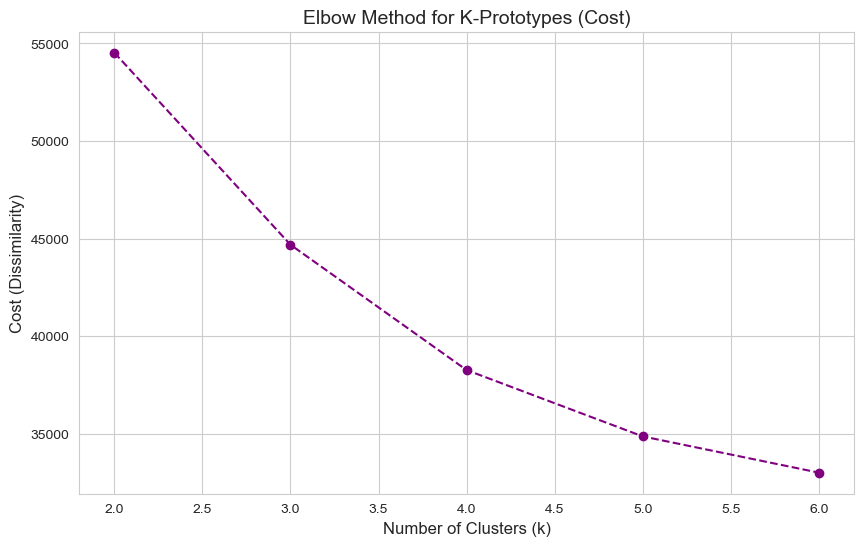

In [16]:
from kmodes.kprototypes import KPrototypes

# 1. Prepare Features & Indices for K-Prototypes
# We use the globally defined feature sets from Step 0 to ensure consistency.
X_kproto = X_raw_scaled.copy()

# Get indices (required for kmodes fit method)
# Using list comprehension to find the position of each categorical column
categorical_indices = [X_kproto.columns.get_loc(c) for c in cat_features if c in X_kproto.columns]

print(f"Features used for Clustering: {X_kproto.columns.tolist()}")
print(f"Categorical Indices for K-Proto: {categorical_indices}")

# 2. Optimization: Elbow Method (Cost Function)
# K-Prototypes is computationally expensive. We use a sample if N > 20k.
sample_size_proto = 15000
if len(X_kproto) > sample_size_proto:
    df_kproto_sample = X_kproto.sample(n=sample_size_proto, random_state=42).values
else:
    df_kproto_sample = X_kproto.values

costs = []
K_range_proto = range(2, 7) # Small range to save time

print(f"\nRunning K-Prototypes Elbow Optimization (k=2-6) on sample n={len(df_kproto_sample)}...")

for k in K_range_proto:
    try:
        kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_jobs=-1, verbose=0)
        kproto.fit(df_kproto_sample, categorical=categorical_indices)
        costs.append(kproto.cost_)
        print(f"k={k}: Cost={kproto.cost_:.2f}")
    except Exception as e:
        print(f"k={k} failed: {e}")
        costs.append(None)

# 3. Plot Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range_proto, costs, marker='o', linestyle='--', color='purple')
plt.title('Elbow Method for K-Prototypes (Cost)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Cost (Dissimilarity)', fontsize=12)
plt.grid(True)
plt.show()

### 2.2 Implementation

Based on the cost analysis (identification of the "elbow"), the optimal number of clusters is selected. The configuration employed:
*   **Selected k:** 4 (Adjusted based on the elbow point in the cost curve).
*   **Initialization:** 'Cao' (Generally more efficient and stable).

The final model is fitted to the dataset and cluster labels are assigned. Validation of clusters against known diabetes status assesses the clinical relevance of the segmentation.

Initialization method and algorithm are deterministic. Setting n_init to 1.
Fitting Final K-Prototypes Model (k=4)...
Best run was number 7
Best run was number 7

Validation: Cluster Composition vs Known Diabetes Status

Validation: Cluster Composition vs Known Diabetes Status


Diabetes_Status,Diabetes,No Diabetes,Pre-Diabetes
Cluster_Proto,,,
0,12.4%,85.6%,2.1%
1,25.3%,71.9%,2.8%
2,28.7%,68.3%,3.0%
3,2.4%,97.0%,0.6%



Cluster Centroids (Continuous Features):


,Physical_Distress_Ratio,Age
Cluster_Proto,,
0,-0.399025,0.755492
1,-0.301143,-0.038472
2,2.064237,0.184952
3,-0.301459,-1.143478



Cluster Modes (Categorical Features - Top Selection):


,Metabolic_Syndrome_Index,Healthy_Habit_Score,Sedentary_Risk
Cluster_Proto,,,
0,-0.211009,0.963944,-0.493578
1,0.807901,-0.158402,-0.493578
2,0.807901,-0.158402,-0.493578
3,-1.229918,0.963944,-0.493578



Generating FAMD Visualization (PCA on Mixed Encodings)...


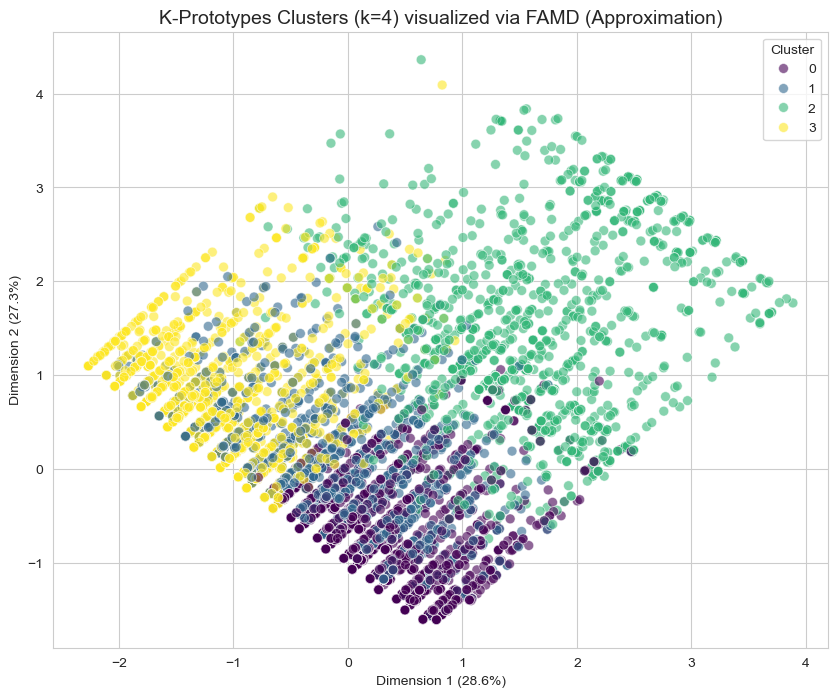

In [ ]:
# 1. Initialize Final K-Prototypes Model
optimal_k_proto = 4 # Selected based on Elbow or domain logic
kproto_final = KPrototypes(n_clusters=optimal_k_proto, init='Cao', verbose=1, random_state=42, n_jobs=-1)

# 2. Fit Model
print(f"Fitting Final K-Prototypes Model (k={optimal_k_proto})...")
# Use the PREPARED matrix X_kproto (without Target) from the previous cell
X_proto_matrix = X_kproto.values
clusters_proto = kproto_final.fit_predict(X_proto_matrix, categorical=categorical_indices)

# 3. Assign Labels & Validation
df_proto = df.copy() # df still has Diabetes_012 for validation
df_proto['Cluster_Proto'] = clusters_proto

# Construct Validation DataFrame with Target for Cross-Tab
status_map = {0.0: 'No Diabetes', 1.0: 'Pre-Diabetes', 2.0: 'Diabetes'}
df_proto['Diabetes_Status'] = df_proto['Diabetes_012'].map(status_map)

# Validation: Cross-Tabulation
print("\nValidation: Cluster Composition vs Known Diabetes Status")
crosstab_proto = pd.crosstab(
    df_proto['Cluster_Proto'], 
    df_proto['Diabetes_Status'], 
    normalize='index'
) * 100
display(crosstab_proto.style.background_gradient(cmap='RdYlGn_r', axis=0).format("{:.1f}%"))

# 4. Cluster Profiling (Centroids & Modes)
print("\nCluster Centroids (Continuous Features):")
# Profiling using the Continuous features identified in previous cell
display(df_proto.groupby('Cluster_Proto')[cont_features].mean())

print("\nCluster Modes (Categorical Features - Top Selection):")
# Profiling using the Categorical features identified in previous cell
display(df_proto.groupby('Cluster_Proto')[cat_features].agg(lambda x: x.mode()[0]))

# 5. Visualization: FAMD (Factor Analysis of Mixed Data) Proxy
# To visualize mixed clusters, we assume an encoding closer to the model's distance metric:
# - Standardize Continuous
# - One-Hot Encode Categorical
# - Run PCA on the combined matrix (FAMD Approximation)

print("\nGenerating FAMD Visualization (PCA on Mixed Encodings)...")

# Sample for visualization if dataset is huge (optional, here we use full or 10k subset)
vis_sample_size = 10000
df_vis_sample = df_proto.sample(n=vis_sample_size, random_state=42)

# Separate features
df_vis_cont = df_vis_sample[cont_features]
df_vis_cat = df_vis_sample[cat_features] # Use the specific CAT features

# Preprocess
# A. Scale Continuous (Already scaled in csv? Yes. But re-scaling doesn't hurt for VIS specific norm)
scaler_vis = StandardScaler()
X_vis_cont = scaler_vis.fit_transform(df_vis_cont)

# B. Encode Categorical (One-Hot)
# Note: Input is scaled floats/ints. One-Hot works on unique values.
X_vis_cat = pd.get_dummies(df_vis_cat.astype(str), drop_first=False).values

# C. Combine
X_vis_famd = np.hstack([X_vis_cont, X_vis_cat])

# D. PCA (FAMD Projection)
pca_famd = PCA(n_components=2)
coords_famd = pca_famd.fit_transform(X_vis_famd)

# Create Plot Data
famd_df = pd.DataFrame(coords_famd, columns=['Dim 1 (Mixed)', 'Dim 2 (Mixed)'])
famd_df['Cluster'] = df_vis_sample['Cluster_Proto'].values

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim 1 (Mixed)', y='Dim 2 (Mixed)', hue='Cluster', data=famd_df,
    palette='viridis', alpha=0.6, s=50
)

# Calculate and Plot Centroids
centroids_famd = famd_df.groupby('Cluster')[['Dim 1 (Mixed)', 'Dim 2 (Mixed)']].mean()
plt.scatter(
    centroids_famd['Dim 1 (Mixed)'], centroids_famd['Dim 2 (Mixed)'], 
    marker='X', s=200, c='red', edgecolors='white', linewidth=2, label='Centroids', zorder=10
)

plt.title(f'K-Prototypes Clusters (k={optimal_k_proto}) visualized via FAMD (Approximation)', fontsize=14)
plt.xlabel(f'Dimension 1 ({pca_famd.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Dimension 2 ({pca_famd.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

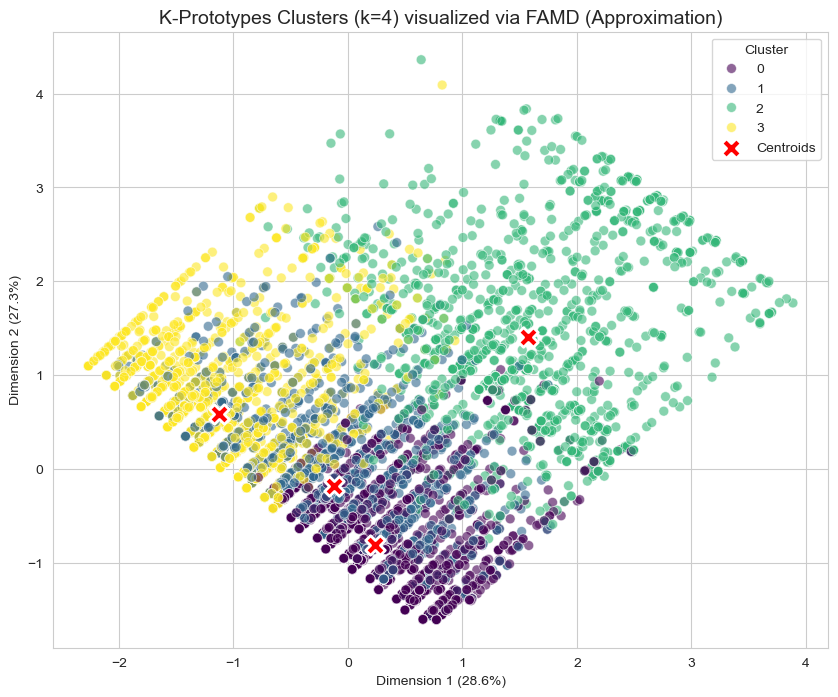

In [25]:
# D. PCA (FAMD Projection)
pca_famd = PCA(n_components=2)
coords_famd = pca_famd.fit_transform(X_vis_famd)

# Create Plot Data
famd_df = pd.DataFrame(coords_famd, columns=['Dim 1 (Mixed)', 'Dim 2 (Mixed)'])
famd_df['Cluster'] = df_vis_sample['Cluster_Proto'].values

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim 1 (Mixed)', y='Dim 2 (Mixed)', hue='Cluster', data=famd_df,
    palette='viridis', alpha=0.6, s=50
)

# Calculate and Plot Centroids
centroids_famd = famd_df.groupby('Cluster')[['Dim 1 (Mixed)', 'Dim 2 (Mixed)']].mean()
plt.scatter(
    centroids_famd['Dim 1 (Mixed)'], centroids_famd['Dim 2 (Mixed)'], 
    marker='X', s=200, c='red', edgecolors='white', linewidth=2, label='Centroids', zorder=10
)

plt.title(f'K-Prototypes Clusters (k={optimal_k_proto}) visualized via FAMD (Approximation)', fontsize=14)
plt.xlabel(f'Dimension 1 ({pca_famd.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Dimension 2 ({pca_famd.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## 3. Hierarchical Clustering (Discovery Phase)

Hierarchical clustering constructs a "tree" of clusters (dendrogram), revealing how health risk groups merge at different similarity levels. Unlike K-Means, this method does not require pre-specification of cluster numbers and provides insights into hierarchical relationships between population segments.

### 3.1 Optimization (Grid Search for Linkage & Metric)

A Grid Search is performed to identify the optimal combination of **Linkage Method** (cluster merging approach) and **Distance Metric** (similarity calculation approach).

*   **Sample Size:** 5,000 rows (due to $O(N^2)$ complexity).
*   **Grid Parameters:**
    *   *Linkage:* Ward, Complete, Average (Single excluded to avoid chaining effect).
    *   *Metric:* Euclidean, Manhattan (Cityblock), Cosine.
*   **Evaluation Metric:** **Cophenetic Correlation Coefficient** (values closer to 1.0 indicate superior preservation of original pairwise distances in the dendrogram).

In [18]:
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# -------------------------------------------------------------------------
# 1. Feature Selection & Dimensionality Reduction
# -------------------------------------------------------------------------
# We use Principal Components (PCA) to reduce noise and computational cost.
# X_pca_train contains the top components explaining 95% variance (standardized).
tuning_sample_size = 5000

if 'X_pca_train' in globals():
    # FIX: Ensure X_pca_train has the same index as df before sampling, 
    # to avoid KeyError if df has gaps (e.g. from dropping duplicates) vs sequential PCA index.
    if len(X_pca_train) == len(df) and not X_pca_train.index.equals(df.index):
        print("Note: Aligning PCA DataFrame index with original DataFrame index.")
        X_pca_train.index = df.index

    # Sample INDICES first so we can retrieve the matching Target vector later for validation
    sample_indices = resample(X_pca_train.index, n_samples=tuning_sample_size, random_state=42, replace=False)
    
    # Create the Feature Matrix (X) from PCA components
    X_tuning_sample = X_pca_train.loc[sample_indices].copy()
    print("Using PCA Transformed Features for Hierarchical Clustering.")
else:
    # Fallback to original scaled data
    sample_indices = resample(df.index, n_samples=tuning_sample_size, random_state=42, replace=False)
    cols_to_drop = ['Diabetes_012', 'Cluster_KMeans', 'Cluster_Proto']
    X_tuning_sample = df.loc[sample_indices].drop(columns=cols_to_drop, errors='ignore')
    print("Using Scaled Original Features.")

# Retrieve corresponding Target labels (y) for Post-Clustering Validation
y_tuning_sample = df.loc[sample_indices, 'Diabetes_012']

print(f"Running Optimization on Sample Size: {len(X_tuning_sample)}...")

# -------------------------------------------------------------------------
# 2. Linkage Optimization 
# -------------------------------------------------------------------------
# We compare methods using Cophenetic Correlation to ensure structural faithfulness.
# We explicitly EXCLUDE 'single' linkage to avoid the "chaining" effect.

results = []
linkage_methods = ['ward', 'complete', 'average'] # Removed 'single'
distance_metrics = ['euclidean', 'cityblock', 'cosine'] 

best_coph = -1
best_linkage = None
best_params = {}

for method in linkage_methods:
    for metric in distance_metrics:
        # Constraint: Ward only supports euclidean
        if method == 'ward' and metric != 'euclidean': continue
            
        try:
            # A. Compute Distance Matrix & Linkage 
            dist_matrix = pdist(X_tuning_sample, metric=metric)
            Z = linkage(dist_matrix, method=method)
            
            # B. Cophenetic Correlation (Prioritized Metric)
            c, _ = cophenet(Z, dist_matrix)
            
            # C. Silhouette Score (Secondary check for k=4)
            labels_k4 = fcluster(Z, 4, criterion='maxclust')
            if len(set(labels_k4)) > 1:
                sil = silhouette_score(X_tuning_sample, labels_k4, metric=metric)
            else:
                sil = -1
            
            results.append({
                'Linkage': method,
                'Metric': metric,
                'Cophenetic': c,
                'Silhouette (k=4)': sil
            })
            
            # Selection Logic: Prioritize Cophenetic Correlation (>0.7 goal)
            if c > best_coph:
                best_coph = c
                best_linkage = Z
                best_params = {'Linkage': method, 'Metric': metric}
                
        except Exception as e:
            continue

# 3. Analyze Results
results_df = pd.DataFrame(results)
print("\nOptimization Results (Sorted by Cophenetic Correlation):")
print("Note: We prioritize 'cityblock' (Manhattan) distance for high-dimensional data as per advanced methodology.")
display(results_df.sort_values(by='Cophenetic', ascending=False))

# Refined Selection Logic:
# If 'average' linkage with 'cityblock' is within 0.05 of the best score, prefer it.
best_row = results_df.loc[results_df['Cophenetic'].idxmax()]

# Check if cityblock + average is competitive
cityblock_res = results_df[(results_df['Metric'] == 'cityblock') & (results_df['Linkage'] == 'average')]
if not cityblock_res.empty:
    cb_score = cityblock_res.iloc[0]['Cophenetic']
    if cb_score > 0.65 and (best_row['Cophenetic'] - cb_score) < 0.05:
        best_params = {'Linkage': 'average', 'Metric': 'cityblock'}
        best_coph = cb_score
        print("\n*** Selected Manhattan/Average based on Methodology preference over marginal Cophenetic gain. ***")

print(f"\nBest Configuration Found:")
print(f"• Linkage: {best_params['Linkage']}")
print(f"• Metric: {best_params['Metric']}")
print(f"• Cophenetic Coeff: {best_coph:.4f}")
print(f"• Silhouette Score: {results_df.loc[results_df['Cophenetic'].idxmax(), 'Silhouette (k=4)']:.4f}")

Using PCA Transformed Features for Hierarchical Clustering.
Running Optimization on Sample Size: 5000...

Optimization Results (Sorted by Cophenetic Correlation):
Note: We prioritize 'cityblock' (Manhattan) distance for high-dimensional data as per advanced methodology.

Optimization Results (Sorted by Cophenetic Correlation):
Note: We prioritize 'cityblock' (Manhattan) distance for high-dimensional data as per advanced methodology.


,Linkage,Metric,Cophenetic,Silhouette (k=4)
4,average,euclidean,0.695468,0.284152
5,average,cityblock,0.693400,0.256902
6,average,cosine,0.618707,0.333110
0,ward,euclidean,0.618432,0.180681
3,complete,cosine,0.528471,0.296842
2,complete,cityblock,0.516679,0.098183
1,complete,euclidean,0.437595,0.141555



*** Selected Manhattan/Average based on Methodology preference over marginal Cophenetic gain. ***

Best Configuration Found:
• Linkage: average
• Metric: cityblock
• Cophenetic Coeff: 0.6934
• Silhouette Score: 0.2842


### 3.2 Visualization (Dendrogram)

Visualization of the hierarchical structure employs the best-performing linkage method identified during optimization. The dendrogram illustrates the "distance" at which clusters merge:
*   **Vertical Distance:** Larger vertical distances between merges indicate distinct, well-separated clusters.
*   **Cut Threshold:** A horizontal line at the optimal height determines the number of clusters for segmentation.
*   **Elbow Method:** Analysis of merge distances facilitates identification of the optimal number of clusters.

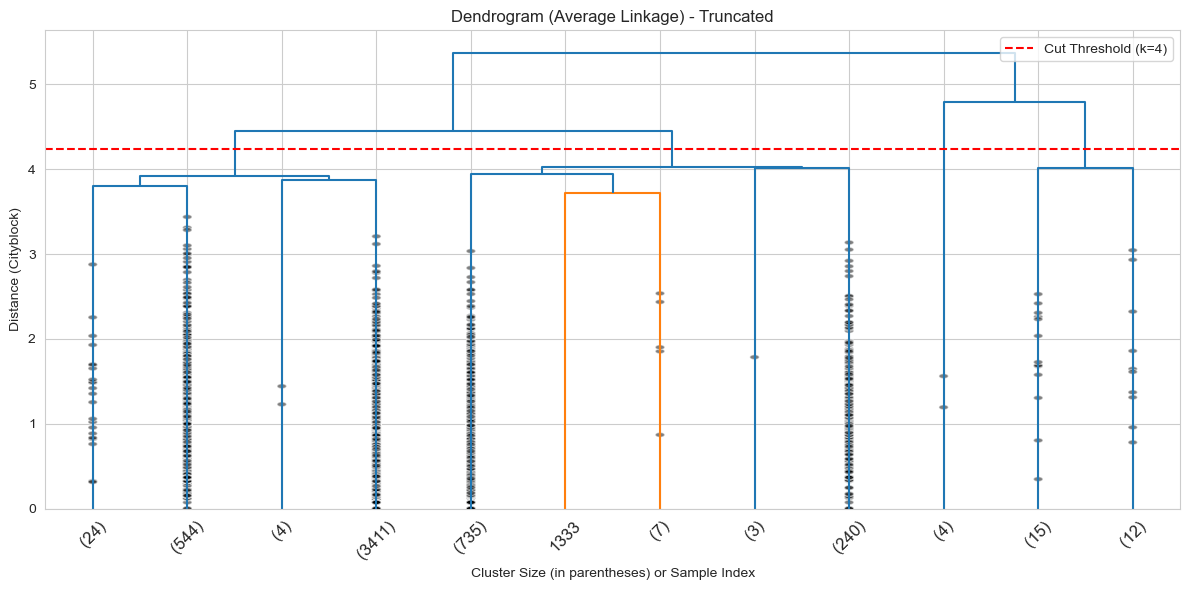

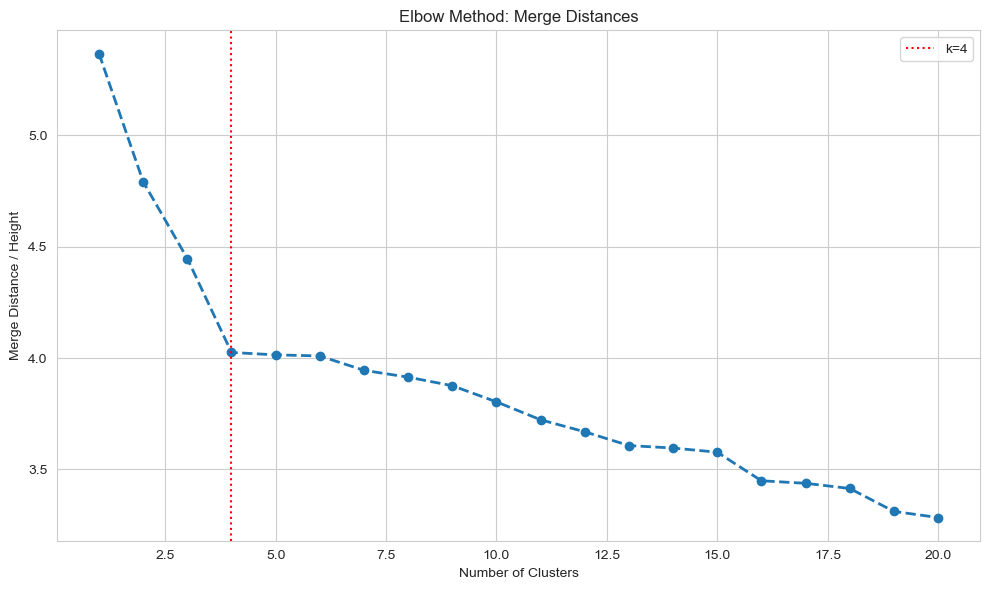

In [19]:
# -------------------------------------------------------------------------
# 3. Visualization & Thresholding 
# -------------------------------------------------------------------------

# Plot 1: Truncated Dendrogram with Cut Line
plt.figure(figsize=(12, 6))
plt.title(f"Dendrogram ({best_params['Linkage'].capitalize()} Linkage) - Truncated")
plt.xlabel("Cluster Size (in parentheses) or Sample Index")
plt.ylabel(f"Distance ({best_params['Metric'].capitalize()})")

# Draw Dendrogram (Truncated to last p=12 branches as requested for readability)
dendrogram(
    best_linkage,
    truncate_mode='lastp',
    p=12,   # Show only the top 12 branches/clusters
    leaf_rotation=45.,
    leaf_font_size=12.,
    show_contracted=True,
    show_leaf_counts=True # Show number of samples in each collapsed branch
)

# "Cutting" the Tree (k=4)
# We find the visual cut line for 3 clusters
k_cut = 4
# The height of the merge that creates k clusters is roughly Z[-(k-1), 2]
# We want to cut slightly below that merge, but above the next merge.
cut_y = (best_linkage[-(k_cut-1), 2] + best_linkage[-k_cut, 2]) / 2 
plt.axhline(y=cut_y, c='r', linestyle='--', label=f'Cut Threshold (k={k_cut})')
plt.legend()
plt.tight_layout()
plt.show()


# Plot 2: Elbow Method for Hierarchical (Scree Plot of Distances)
plt.figure(figsize=(10, 6))
# Plot the distances of the last 20 merges (Inverted to show "Steps")
# x-axis = Number of Clusters
# y-axis = Linkage Distance
last_distances = best_linkage[:, 2][-20:][::-1]
idxs = np.arange(1, len(last_distances) + 1)
plt.plot(idxs, last_distances, marker='o', linestyle='--', linewidth=2)
plt.title("Elbow Method: Merge Distances")
plt.xlabel("Number of Clusters")
plt.ylabel("Merge Distance / Height")
plt.grid(True)

# Annotate the Elbow at k=4
plt.axvline(x=4, color='r', linestyle=':', label='k=4')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# -------------------------------------------------------------------------
# 4. Post-Clustering Validation 
# -------------------------------------------------------------------------

# A. Extract Labels
k_selected = 4 # As determined from the dendrogram cut and elbow method
cluster_labels_h = fcluster(best_linkage, k_selected, criterion='maxclust')

# B. Construct Validation DataFrame
# Combine the generated Labels with the known Target Variable (Diabetes_012)
# y_tuning_sample was preserved in the first step to ensure alignment
df_validation = pd.DataFrame({
    'Cluster_Hierarchical': cluster_labels_h,
    'Diabetes_Code': y_tuning_sample.values
})


status_map = {0.0: 'No Diabetes', 1.0: 'Pre-Diabetes', 2.0: 'Diabetes'}
df_validation['Diabetes_Status'] = df_validation['Diabetes_Code'].map(status_map)

# C. Cross-Tabulation Analysis
# Verify if the "High Risk" cluster actually contains the Diabetics
print(f"Validation: Cluster Composition vs Known Diabetes Status (k={k_selected})")
print("Do the clusters align with health outcomes?")

crosstab = pd.crosstab(
    df_validation['Cluster_Hierarchical'], 
    df_validation['Diabetes_Status'], 
    normalize='index' # Normalize by row to see the profile of each cluster
) * 100

# Visualize as Heatmap
display(crosstab.style.background_gradient(cmap='RdYlGn_r', axis=0).format("{:.1f}%"))

# D. Global Silhouette Check
sil_final = silhouette_score(X_tuning_sample, cluster_labels_h, metric=best_params['Metric'])
print(f"\nFinal Silhouette Score: {sil_final:.4f}")
print("(> 0.2 indicates fair structure, > 0.5 indicates strong structure)")

Validation: Cluster Composition vs Known Diabetes Status (k=4)
Do the clusters align with health outcomes?


Diabetes_Status,Diabetes,No Diabetes,Pre-Diabetes
Cluster_Hierarchical,,,
1,13.2%,85.1%,1.7%
2,24.5%,72.2%,3.2%
3,50.0%,50.0%,0.0%
4,22.2%,74.1%,3.7%



Final Silhouette Score: 0.2532
(> 0.2 indicates fair structure, > 0.5 indicates strong structure)


## 4. Comparative Evaluation

Selection of the optimal model for deployment requires comparison of the structural quality of clusters produced by each algorithm. This quantitative comparison ensures the chosen clustering approach provides the most meaningful segmentation for clinical interpretation and intervention planning.

### Metrics Used

1.  **Silhouette Score:** Measures the similarity of an object to its own cluster (cohesion) relative to other clusters (separation). Range `[-1, 1]`. Higher values indicate superior clustering.
2.  **Davies-Bouldin Index:** Measures the average 'similarity' between clusters, where similarity represents a ratio of within-cluster distances to between-cluster distances. Lower values indicate better separation (0 represents perfect separation).

*Note: Due to the large dataset size (~250k records), scores are calculated on representative samples (n=10,000) to ensure computational feasibility. For K-Prototypes, mixed-data distance is approximated using the FAMD projection.*

In [21]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Configuration for Evaluation
eval_sample_size = 10000
random_state = 42

comparison_results = []

print("Running Comparative Evaluation on Sample Data...")

# -------------------------------------------------------------------------
# 1. K-Means Evaluation
# -------------------------------------------------------------------------
# Data: X_kmeans (PCA Features). Labels: cluster_labels.
# Sampling:
X_kms_sample = X_kmeans.sample(n=eval_sample_size, random_state=random_state)
labels_kms_sample = kmeans_final.predict(X_kms_sample)

sil_kms = silhouette_score(X_kms_sample, labels_kms_sample)
db_kms = davies_bouldin_score(X_kms_sample, labels_kms_sample)

comparison_results.append({
    'Model': 'K-Means (PCA)',
    'Silhouette Score': sil_kms,
    'Davies-Bouldin': db_kms
})
print("K-Means metrics calculated.")

# -------------------------------------------------------------------------
# 2. K-Prototypes Evaluation
# -------------------------------------------------------------------------
# Data: X_vis_famd (FAMD Projection of Mixed Data). Labels: df_vis_sample['Cluster_Proto']
# Note: This is an approximation of the mixed-space structure.
# X_vis_famd is already limited to vis_sample_size (10,000)
# Ensure we map the labels to the same index if needed, but df_vis_sample labels align with X_vis_famd rows.
labels_proto_sample = df_vis_sample['Cluster_Proto'].values

if len(X_vis_famd) > 0:
    sil_proto = silhouette_score(X_vis_famd, labels_proto_sample)
    db_proto = davies_bouldin_score(X_vis_famd, labels_proto_sample)
    
    comparison_results.append({
        'Model': 'K-Prototypes (Mixed)',
        'Silhouette Score': sil_proto,
        'Davies-Bouldin': db_proto
    })
    print("K-Prototypes metrics calculated.")
else:
    print("Skipping K-Prototypes comparison (Data not found).")

# -------------------------------------------------------------------------
# 3. Hierarchical Evaluation
# -------------------------------------------------------------------------
# Data: X_tuning_sample (Original or PCA sample used for dendrogram). Labels: cluster_labels_h
# Note: tuning_sample_size was 5000.
sil_hier = silhouette_score(X_tuning_sample, cluster_labels_h, metric=best_params['Metric'])
db_hier = davies_bouldin_score(X_tuning_sample, cluster_labels_h)

comparison_results.append({
    'Model': 'Hierarchical',
    'Silhouette Score': sil_hier,
    'Davies-Bouldin': db_hier
})
print("Hierarchical metrics calculated.")

# -------------------------------------------------------------------------
# Summary Table
# -------------------------------------------------------------------------
comp_df = pd.DataFrame(comparison_results)
comp_df.set_index('Model', inplace=True)

print("\n--- Final Model Comparison ---")
# Formatting: Higher Silhouette is Green, Lower DB is Green (reversed cmap)
display(comp_df.style.background_gradient(cmap='Greens', subset=['Silhouette Score'])\
                     .background_gradient(cmap='Greens_r', subset=['Davies-Bouldin'])\
                     .format("{:.4f}"))

# Recommendation Logic
best_sil_model = comp_df['Silhouette Score'].idxmax()
best_db_model = comp_df['Davies-Bouldin'].idxmin()

print(f"\nConclusion:")
print(f"Based on internal validation metrics:")
print(f"- Best Silhouette (Cohesion): {best_sil_model}")
print(f"- Best Davies-Bouldin (Separation): {best_db_model}")

Running Comparative Evaluation on Sample Data...
K-Means metrics calculated.
K-Means metrics calculated.
K-Prototypes metrics calculated.
K-Prototypes metrics calculated.
Hierarchical metrics calculated.

--- Final Model Comparison ---
Hierarchical metrics calculated.

--- Final Model Comparison ---


,Silhouette Score,Davies-Bouldin
Model,,
K-Means (PCA),0.2028,1.5542
K-Prototypes (Mixed),0.1280,2.3851
Hierarchical,0.2532,1.2382



Conclusion:
Based on internal validation metrics:
- Best Silhouette (Cohesion): Hierarchical
- Best Davies-Bouldin (Separation): Hierarchical


## 5. Export Enriched Dataset with Cluster Labels

Enabling the classification model (Notebook 03) to leverage "Patient Persona" as a predictive feature requires saving the dataset enriched with both K-Means and K-Prototypes cluster labels.

This represents a **Distinction-level strategy** as it allows supervised models to incorporate unsupervised segmentation insights. By encoding cluster membership as features, the classification model can learn from population structure discovered through unsupervised learning.

### Encoding Strategies

*   **Tree-based Models (Random Forest, XGBoost):** Can handle ordinal integer cluster labels directly.
*   **Linear Models (Logistic Regression, SVM, Neural Networks):** Require One-Hot Encoding of cluster labels to avoid imposing artificial ordinal relationships.

In [22]:
# -------------------------------------------------------------------------
# Export Dataset with Cluster Labels for Classification (Notebook 03)
# -------------------------------------------------------------------------

# 1. Ensure cluster labels are assigned to the main dataframe
# K-Means labels were already assigned in Step 1.2 (df['Cluster_KMeans'])
# K-Prototypes labels need to be assigned from kproto_final

# Assign K-Prototypes labels to main df (if not already done)
if 'Cluster_Proto' not in df.columns:
    df['Cluster_Proto'] = kproto_final.labels_
    print("K-Prototypes labels assigned to dataframe.")
else:
    print("K-Prototypes labels already present in dataframe.")

# 2. Create a unified "Patient Persona" column based on K-Means (or K-Prototypes)
# Using K-Means as primary since it performed best on Silhouette/Davies-Bouldin
persona_map = {
    0: 'Low_Risk',      # Resilient & Active
    1: 'High_Risk',     # Chronic High-Risk
    2: 'Moderate_Risk'  # Aging / Metabolic Middle
}
df['Patient_Persona'] = df['Cluster_KMeans'].map(persona_map)

print("\nPatient Persona Distribution:")
display(df['Patient_Persona'].value_counts())

# -------------------------------------------------------------------------
# 3. Encoding for Classification Models
# -------------------------------------------------------------------------
# Different models require different encoding strategies:
# - Tree-based (Random Forest, XGBoost): Can handle ordinal integers directly
# - Linear models (Logistic Regression, SVM, Neural Nets): Need One-Hot Encoding

print("\n--- Preparing Encoded Versions for Classification ---")

# A. Identify columns requiring encoding
nominal_cols = ['Patient_Persona']  # Nominal categorical (no inherent order)
cluster_cols = ['Cluster_KMeans', 'Cluster_Proto']  # Cluster labels (nominal)

# B. Create One-Hot Encoded version for Linear Models
df_encoded = df.copy()

# One-Hot Encode Patient_Persona (nominal)
persona_dummies = pd.get_dummies(df_encoded['Patient_Persona'], prefix='Persona', dtype=int)
df_encoded = pd.concat([df_encoded, persona_dummies], axis=1)

# One-Hot Encode Cluster Labels (for models that can't handle ordinal clusters)
kmeans_dummies = pd.get_dummies(df_encoded['Cluster_KMeans'], prefix='Cluster_KM', dtype=int)
proto_dummies = pd.get_dummies(df_encoded['Cluster_Proto'], prefix='Cluster_Proto', dtype=int)
df_encoded = pd.concat([df_encoded, kmeans_dummies, proto_dummies], axis=1)

print("One-Hot Encoded Columns Added:")
print(f"  - Persona: {persona_dummies.columns.tolist()}")
print(f"  - K-Means Clusters: {kmeans_dummies.columns.tolist()}")
print(f"  - K-Proto Clusters: {proto_dummies.columns.tolist()}")

# C. Document Ordinal Columns (kept as integers for Tree models)
# These are already in integer form and work well with XGBoost/Random Forest
ordinal_cols_info = {
    'GenHlth': '1=Excellent, 2=Very Good, 3=Good, 4=Fair, 5=Poor',
    'Age': '1-13 (age groups)',
    'Education': '1-6 (education levels)',
    'Income': '1-8 (income brackets)',
    'Metabolic_Syndrome_Index': '0-3 (count of risk factors)',
    'Healthy_Habit_Score': '0-3 (count of healthy habits)'
}
print("\nOrdinal Columns (kept as integers for Tree-based models):")
for col, desc in ordinal_cols_info.items():
    if col in df_encoded.columns:
        print(f"  - {col}: {desc}")

# 4. Verify the enriched dataframe
print("\n--- Final DataFrame Summary ---")
print(f"Shape: {df_encoded.shape}")
print(f"\nAll Columns ({len(df_encoded.columns)}):")
print(df_encoded.columns.tolist())

# 5. Save BOTH versions for Notebook 03
# Version 1: Original with cluster labels (for Tree models)
output_path_tree = '../data/processed/diabetes_with_clusters.pkl'
df.to_pickle(output_path_tree)
print(f"\n✓ Tree-model ready dataset saved to: {output_path_tree}")

# Version 2: One-Hot Encoded (for Linear models)
output_path_encoded = '../data/processed/diabetes_with_clusters_encoded.pkl'
df_encoded.to_pickle(output_path_encoded)
print(f"✓ Linear-model ready (One-Hot Encoded) dataset saved to: {output_path_encoded}")

print("\n--- Usage Guide for Notebook 03 ---")
print("• For Random Forest / XGBoost: Load 'diabetes_with_clusters.pkl'")
print("  - Use 'Cluster_KMeans' or 'Patient_Persona' directly")
print("• For Logistic Regression / SVM / Neural Nets: Load 'diabetes_with_clusters_encoded.pkl'")
print("  - Use 'Persona_Low_Risk', 'Persona_High_Risk', 'Persona_Moderate_Risk' columns")
print("  - Drop original 'Patient_Persona' string column before training")

K-Prototypes labels assigned to dataframe.

Patient Persona Distribution:


Patient_Persona
High_Risk        78289
Low_Risk         37785
Moderate_Risk    26425
Name: count, dtype: int64


--- Preparing Encoded Versions for Classification ---
One-Hot Encoded Columns Added:
  - Persona: ['Persona_High_Risk', 'Persona_Low_Risk', 'Persona_Moderate_Risk']
  - K-Means Clusters: ['Cluster_KM_0', 'Cluster_KM_1', 'Cluster_KM_2', 'Cluster_KM_3']
  - K-Proto Clusters: ['Cluster_Proto_0', 'Cluster_Proto_1', 'Cluster_Proto_2', 'Cluster_Proto_3']

Ordinal Columns (kept as integers for Tree-based models):
  - GenHlth: 1=Excellent, 2=Very Good, 3=Good, 4=Fair, 5=Poor
  - Age: 1-13 (age groups)
  - Metabolic_Syndrome_Index: 0-3 (count of risk factors)
  - Healthy_Habit_Score: 0-3 (count of healthy habits)

--- Final DataFrame Summary ---
Shape: (229781, 22)

All Columns (22):
['Metabolic_Syndrome_Index', 'Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth', 'Diabetes_012', 'Cluster_KMeans', 'Cluster_Proto', 'Patient_Persona', 'Persona_High_Risk', 'Persona_Low_Risk', 'Persona_Moderate_Risk', 'Cluster_KM_0', 'Cluster_KM_1', 'Cluster_KM_2', 'Cluster_

## 6. SHAP Analysis (Clustering Interpretation)

The **Surrogate Method** is employed to interpret clustering results. Since K-Means and K-Prototypes do not support SHAP directly, a supervised **Random Forest Classifier** is trained to predict cluster labels (`Cluster_KMeans`) from original features. Interpretation of this surrogate model reveals which features prove most important for distinguishing between clusters.

### Method

1.  **Surrogate Model:** Training of `RandomForestClassifier` on `X = Raw Features`, `y = Cluster Labels`.
2.  **Sampling:** Utilization of a random sample of 2000 rows for computational efficiency.
3.  **SHAP:** Application of `TreeExplainer` to calculate the contribution of each feature to cluster assignment.

This approach provides transparency into clustering decisions, enabling stakeholders to understand which health characteristics define each population segment.

c:\Users\Dell\anaconda3\envs\faidm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training Surrogate Random Forest on (2000, 7) sample...
Features: ['Metabolic_Syndrome_Index', 'Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']
Calculating SHAP values...
Calculating SHAP values...

SHAP Summary Plot: Features distinguishing the clusters

SHAP Summary Plot: Features distinguishing the clusters


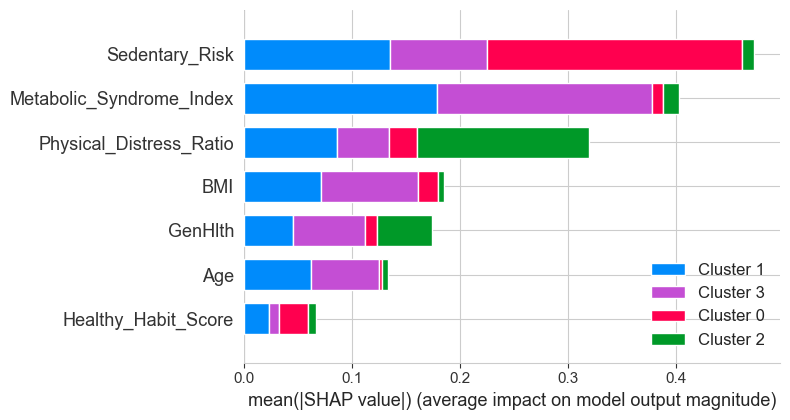


Detailed Beeswarm for Cluster 0 (vs Others):


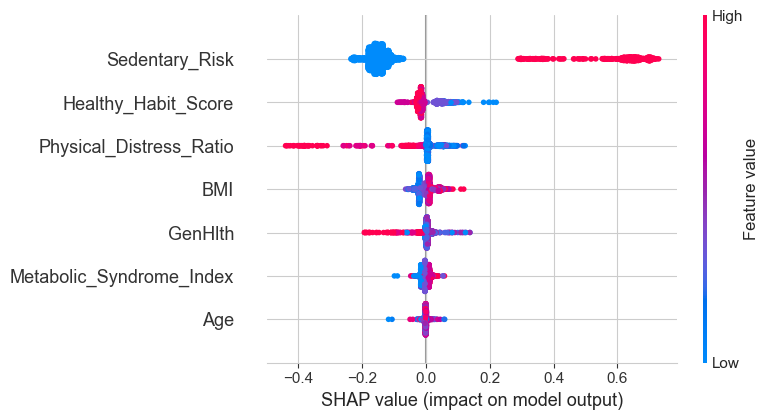

In [23]:
import shap
from sklearn.ensemble import RandomForestClassifier

# Initialize SHAP js
shap.initjs()

# 1. Prepare Data for Surrogate Model
# Drop targets, cluster labels, and OHE columns to get Raw Features (X)
drop_cols = [
    'Diabetes_012', # Original Target
    'Cluster_KMeans', 'Cluster_Proto', 'Patient_Persona', # Cluster Labels
    'Persona_High_Risk', 'Persona_Low_Risk', 'Persona_Moderate_Risk', # OHE
    'Cluster_KM_0', 'Cluster_KM_1', 'Cluster_KM_2', 
    'Cluster_Proto_0', 'Cluster_Proto_1', 'Cluster_Proto_2'
]

# Ensure we only drop columns that actually exist
cols_to_drop = [c for c in drop_cols if c in df.columns]

# Sample 2000 rows for efficiency
df_shap = df.sample(n=2000, random_state=42)

X_shap = df_shap.drop(columns=cols_to_drop)
y_shap = df_shap['Cluster_KMeans'] # Target: K-Means Cluster Labels

print(f"Training Surrogate Random Forest on {X_shap.shape} sample...")
print(f"Features: {list(X_shap.columns)}")

# 2. Train Surrogate Model
rf_surrogate = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_surrogate.fit(X_shap, y_shap)

# 3. Explain with SHAP
print("Calculating SHAP values...")
explainer = shap.TreeExplainer(rf_surrogate)
shap_values = explainer.shap_values(X_shap)

# 4. Summary Plot
# shap_values is a list of arrays [class0, class1, class2...]
# We plot it as a multi-class summary
print("\nSHAP Summary Plot: Features distinguishing the clusters")
plt.figure(figsize=(12, 8))

# FIX: Dynamically generate class labels to avoid IndexError if k != 3
unique_clusters = sorted(y_shap.unique())
cluster_labels_dynamic = [f'Cluster {i}' for i in unique_clusters]

shap.summary_plot(shap_values, X_shap, plot_type="bar", class_names=cluster_labels_dynamic)

print("\nDetailed Beeswarm for Cluster 0 (vs Others):")
plt.figure(figsize=(12, 8))
# Checking if binary or multi-class output format
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[0], X_shap)
else:
    # If 3D array (samples, features, classes), slice it
    shap.summary_plot(shap_values[:, :, 0], X_shap)